In [1]:
from brian2 import *
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema

%matplotlib inline
seed(12345)

In [2]:
start_scope()

################################################################################
# Model parameters
################################################################################
### General parameters
duration = 1*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step

N_sst = 2 # Number of SST neurons (inhibitory)
N_pv = 2  # Number of PV neurons (inhibitory)
N_cc = 2  # Number of CC neurons (excitatory)
N_cs = 2  # Number of CS neurons (excitatory)

### Neuron parameters
tau_S   = 16*ms  # 
tau_D   =  7*ms  #
tau_SST = 20*ms  #
tau_PV  = 10*ms  #
tau_E   =  5*ms  # Excitatory synaptic time constant
tau_I   = 10*ms  # Inhibitory synaptic time constant

C_S   = 370*pF
C_D   = 170*pF
C_SST = 100*pF
C_PV  = 100*pF

E_l  = -70*mV   # leak reversal potential
E_e  =   0*mV   # Excitatory synaptic reversal potential
E_i  = -80*mV   # Inhibitory synaptic reversal potential

V_t  = -50*mV   # spiking threashold
V_r  = E_l      # reset potential

c_d = 2600 * pA  # back-propagates somatic spikes to to the dendrites
g_s = 1300 * pA  # propagates dendritic regenerative activity to soma
g_d = 1200 * pA  # propagates dendritic regenerative activity to denderites


### Synapse parameters
w_e = 0.05*nS  # Excitatory synaptic conductance
w_i = 1.0*nS   # Inhibitory synaptic conductance


### External Input
g = 500*pA
M = 1.05 
I_ext_sst = [0*pA for i in range(N_sst)]
I_ext_pv = [0*pA for i in range(N_pv)]
I_ext_cs = I_ext_cc = [g, g*M]
lambda_cs = lambda_cc = 10*Hz

################################################################################

In [3]:
### Sigmoid function params
E_d = -38*mV  # position control of threshold
D_d =   6*mV  # sharpness control of threshold 

# TODO see how to reference this from equation 
@check_units(x=volt, result=1)
def sigmoid(x):
    return 1/(1+np.exp(-(-x-E_d)/D_d))

In [4]:
eqs_sst_inh = '''
    dv/dt = ((E_l-v)/tau_SST + I/C_SST) : volt (unless refractory)

    dg_e/dt = -g_e/tau_E : siemens
    dg_i/dt = -g_i/tau_I : siemens

    I = I_external + I_syn : amp
    I_syn = g_e*(E_e - v) + g_i*(E_i - v) : amp
    I_external : amp
'''

eqs_pv_inh = '''
    dv/dt = ((E_l-v)/tau_PV + I/C_PV) : volt (unless refractory)

    dg_e/dt = -g_e/tau_E : siemens
    dg_i/dt = -g_i/tau_I : siemens

    I = I_external + I_syn : amp
    I_syn = g_e*(E_e - v) + g_i*(E_i - v) : amp
    I_external : amp
'''

eqs_exc = '''
    dv_s/dt = ((E_l-v_s)/tau_S + (g_s*(1/(1+exp(-(v_d-E_d)/D_d))) + I_s)/C_S) : volt (unless refractory)

    dg_es/dt = -g_es/tau_E : siemens
    dg_is/dt = -g_is/tau_I : siemens

    I_s = I_external + I_syn_s : amp
    I_syn_s = g_es*(E_e - v_s) + g_is*(E_i - v_s) : amp
    I_external : amp

    dv_d/dt = ((E_l-v_d)/tau_D + (g_d*(1/(1+exp(-(v_d-E_d)/D_d))) + c_d*K + I_d)/C_D) : volt

    dg_ed/dt = -g_ed/tau_E : siemens
    dg_id/dt = -g_id/tau_I : siemens

    I_d = I_syn_d : amp
    I_syn_d = g_ed*(E_e - v_d) + g_id*(E_i - v_d) : amp
    K : 1
'''

In [5]:
# SST Neurons
sst_neurons = NeuronGroup(N_sst, model=eqs_sst_inh, threshold='v > V_t',
                              reset='v = E_l', refractory=8.3 * ms, method='euler')
sst_neurons.set_states({'I_external': I_ext_sst})
sst_neurons.v = 'E_l + rand()*(V_t-E_l)'
sst_neurons.g_e = 'rand()*w_e'
sst_neurons.g_i = 'rand()*w_i'

# PV Neurons
pv_neurons = NeuronGroup(N_pv, model=eqs_pv_inh, threshold='v > V_t',
                             reset='v = E_l', refractory=8.3 * ms, method='euler')
pv_neurons.set_states({'I_external': I_ext_pv})
pv_neurons.v = 'E_l + rand()*(V_t-E_l)'
pv_neurons.g_e = 'rand()*w_e'
pv_neurons.g_i = 'rand()*w_i'

# CS Neurons
cs_neurons = NeuronGroup(N_cs, model=eqs_exc, threshold='v_s > V_t',
                             reset='v_s = E_l', refractory=8.3 * ms, method='euler')
cs_neurons.v_s = 'E_l + rand()*(V_t-E_l)'
cs_neurons.v_d = -70 * mV
cs_neurons.g_es = cs_neurons.g_ed = 'rand()*w_e'
cs_neurons.g_is = cs_neurons.g_id = 'rand()*w_i'

# Poisson input to CS neurons
cs_neurons_p1 = PoissonInput(cs_neurons[0], 'I_external', N=1, rate=lambda_cs, weight=I_ext_cs[0])
cs_neurons_p2 = PoissonInput(cs_neurons[1], 'I_external', N=1, rate=lambda_cs, weight=I_ext_cs[1])

# CC Neurons
cc_neurons = NeuronGroup(N_cc, model=eqs_exc, threshold='v_s > V_t',
                             reset='v_s = E_l', refractory=8.3 * ms, method='euler')
cc_neurons.v_s = 'E_l + rand()*(V_t-E_l)'
cc_neurons.v_d = -70 * mV
cc_neurons.g_es = cc_neurons.g_ed = 'rand()*w_e'
cc_neurons.g_is = cc_neurons.g_id = 'rand()*w_i'

# Poisson input to CC neurons
cc_neurons_p1 = PoissonInput(cc_neurons[0], 'I_external', N=1, rate=lambda_cc, weight=I_ext_cc[0])
cc_neurons_p2 = PoissonInput(cc_neurons[1], 'I_external', N=1, rate=lambda_cc, weight=I_ext_cc[1])

In [6]:
# CS_CS 0, CS_SST 1, CS_PV 2, SST_CS 3, PV_CS 4, CC_CC 5, CC_SST 6, CC_PV 7, SST_CC 8, PV_CC 9, CC_CS 10, SST_PV 11, SST_SST 12, PV_PV 13, PV_SST 14, 
# conn_probs = [0.16, 0.23, 0.18, 0.52, 0.43, 0.06, 0.26, 0.22, 0.13, 0.38, 0.09, 0.29, 0.1, 0.5, 0.14]
conn_probs = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# SST <=> PV
conn_SST_PV = Synapses(sst_neurons, pv_neurons, on_pre='g_i+=w_i', name='SST_PV') # inhibitory
conn_SST_PV.connect(p=conn_probs[11])
conn_PV_SST = Synapses(pv_neurons, sst_neurons, on_pre='g_i+=w_i', name='PV_SST') # inhibitory
conn_PV_SST.connect(p=conn_probs[14])

# PV <=> PYR soma
## target CS soma
conn_PV_CSsoma = Synapses(pv_neurons, cs_neurons, on_pre='g_is+=w_i', name='PV_CSsoma') # inhibitory
conn_PV_CSsoma.connect(p=conn_probs[4])
conn_CSsoma_PV = Synapses(cs_neurons, pv_neurons, on_pre='g_e+=w_e', name='CSsoma_PV') # excitatory
conn_CSsoma_PV.connect(p=conn_probs[2])

## target CC soma
conn_PV_CCsoma = Synapses(pv_neurons, cc_neurons, on_pre='g_is+=w_i', name='PV_CCsoma') # inhibitory 
conn_PV_CCsoma.connect(p=conn_probs[9])
conn_CCsoma_PV = Synapses(cc_neurons, pv_neurons, on_pre='g_e+=w_e', name='CCsoma_PV') # excitatory
conn_CCsoma_PV.connect(p=conn_probs[7])

# SST <=> PYR soma
## target CS soma
conn_SST_CSsoma = Synapses(sst_neurons, cs_neurons, on_pre='g_is+=w_i', name='SST_CSsoma') # inhibitory (optional connection)
conn_SST_CSsoma.connect(p=conn_probs[3])
conn_CSsoma_SST = Synapses(cs_neurons, sst_neurons, on_pre='g_e+=w_e', name='CSsoma_SST') # excitatory
conn_CSsoma_SST.connect(p=conn_probs[1])

## taget CC soma
conn_SST_CCsoma = Synapses(sst_neurons, cc_neurons, on_pre='g_is+=w_i', name='SST_CCsoma') # inhibitory (optional connection)
conn_SST_CCsoma.connect(p=conn_probs[8])
conn_CCsoma_SST = Synapses(cc_neurons, sst_neurons, on_pre='g_e+=w_e', name='CCsoma_SST') # excitatory
conn_CCsoma_SST.connect(p=conn_probs[6])

# CC => CS 
## target CS soma
conn_SST_CCdendrite = Synapses(cc_neurons, cs_neurons, on_pre='g_es+=w_e', name='CC_CSsoma') # excitatory
conn_SST_CCdendrite.connect(p=conn_probs[10])

# self connections
conn_CSsoma_CSsoma = Synapses(cs_neurons, cs_neurons, on_pre='g_es+=w_e', name='CSsoma_CSsoma')  # excitatory
conn_CSsoma_CSsoma.connect(p=conn_probs[0])
backprop_CS = Synapses(cs_neurons, cs_neurons, on_pre={'up': 'K += 1', 'down': 'K -=1'},
                           delay={'up': 0.5 * ms, 'down': 2 * ms}, name='backprop_CS')
backprop_CS.connect(condition='i==j')  # Connect all CS neurons to themselves

conn_CCsoma_CCsoma = Synapses(cc_neurons, cc_neurons, on_pre='g_es+=w_e', name='CCsoma_CCsoma')  # excitatory
conn_CCsoma_CCsoma.connect(p=conn_probs[5])
backprop_CC = Synapses(cc_neurons, cc_neurons, on_pre={'up': 'K += 1', 'down': 'K -=1'},
                           delay={'up': 0.5 * ms, 'down': 2 * ms}, name='backprop_CC')
backprop_CC.connect(condition='i==j')  # Connect all CC neurons to themselves

conn_SST_SST = Synapses(sst_neurons, sst_neurons, on_pre='g_i+=w_i', name='SST_SST')  # inhibitory
conn_SST_SST.connect(p=conn_probs[12])

conn_PV_PV = Synapses(pv_neurons, pv_neurons, on_pre='g_i+=w_i', name='PV_PV')  # inhibitory
conn_PV_PV.connect(p=conn_probs[13])


# SST => PYR dendrite
## target CS dendrite
conn_SST_CSdendrite = Synapses(sst_neurons, cs_neurons, on_pre='g_id+=w_i', name='SST_CSdendrite') # inhibitory
conn_SST_CSdendrite.connect(p=conn_probs[3]) # not sure about this here

## target CC dendrite
conn_SST_CCdendrite = Synapses(sst_neurons, cc_neurons, on_pre='g_id+=w_i', name='SST_CCdendrite') # inhibitory
conn_SST_CCdendrite.connect(p=conn_probs[8]) # not sure about this here



WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


In [7]:
# ##############################################################################
# # Monitors
# ##############################################################################

# Record spikes of different neuron groups
spike_mon_sst = SpikeMonitor(sst_neurons)
spike_mon_pv = SpikeMonitor(pv_neurons)
spike_mon_cs = SpikeMonitor(cs_neurons)
spike_mon_cc = SpikeMonitor(cc_neurons)

# Record conductances and membrane potential of neuron ni
state_mon_sst = StateMonitor(sst_neurons, ['v', 'g_e', 'g_i'], record=[0])
state_mon_pv = StateMonitor(pv_neurons, ['v', 'g_e', 'g_i'], record=[0])
state_mon_cs = StateMonitor(cs_neurons, ['v_s', 'v_d', 'g_es', 'g_is', 'g_ed', 'g_id'], record=[0])
state_mon_cc = StateMonitor(cc_neurons, ['v_s', 'v_d', 'g_es', 'g_is', 'g_ed', 'g_id'], record=[0])

In [8]:
# ##############################################################################
# # Simulation run
# ##############################################################################

defaultclock.dt = sim_dt

run(duration, report='text')

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 1s


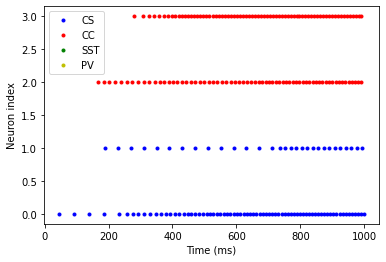

In [9]:
################################################################################
# Analysis and plotting
################################################################################

# Raster plot
plot(spike_mon_cs.t / ms, 0 + spike_mon_cs.i, '.b', label='CS')
plot(spike_mon_cc.t / ms, N_cs + spike_mon_cc.i, '.r', label='CC')
plot(spike_mon_sst.t / ms, (N_cs + N_cc) + spike_mon_sst.i, '.g', label='SST')
plot(spike_mon_pv.t / ms, (N_cs + N_cc + N_sst) + spike_mon_pv.i, '.y', label='PV')
xlabel('Time (ms)')
ylabel('Neuron index');
legend(loc='best')

Spike times CS: [0.046  0.0928 0.1396 0.1864 0.1888 0.2292 0.233  0.2577 0.2695 0.2756
 0.2935 0.3098 0.3114 0.3293 0.3472 0.35   0.3651 0.3791 0.3902 0.3931
 0.4071 0.421  0.4304 0.4349 0.4472 0.4595 0.4706 0.4717 0.4839 0.4958
 0.5068 0.5108 0.5175 0.5282 0.5389 0.5496 0.551  0.5603 0.571  0.5813
 0.5912 0.5916 0.6019 0.6122 0.6225 0.6314 0.6326 0.6427 0.6528 0.6627
 0.6715 0.6726 0.6825 0.6924 0.7023 0.7117 0.7122 0.7221 0.7318 0.7355
 0.7415 0.7512 0.7528 0.7609 0.77   0.7705 0.7801 0.7872 0.7897 0.7993
 0.8044 0.8089 0.8184 0.8216 0.8279 0.8374 0.8388 0.8469 0.856  0.8564
 0.8659 0.8732 0.8754 0.8849 0.8904 0.8944 0.9039 0.9076 0.9134 0.9229
 0.9248 0.9324 0.9419 0.942  0.9514 0.9592 0.9609 0.9704 0.9764 0.9799
 0.9894 0.9936 0.9989] s


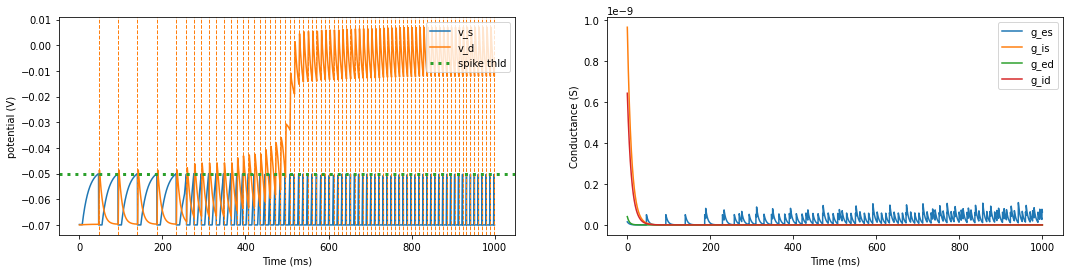

In [10]:
# CS Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_cs.t / ms, state_mon_cs.v_s[0], label='v_s')
plot(state_mon_cs.t / ms, state_mon_cs.v_d[0], label='v_d')
for (t, i) in zip(spike_mon_cs.t, spike_mon_cs.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_cs.t / ms, state_mon_cs.g_es[0], label='g_es')
plot(state_mon_cs.t / ms, state_mon_cs.g_is[0], label='g_is')
plot(state_mon_cs.t / ms, state_mon_cs.g_ed[0], label='g_ed')
plot(state_mon_cs.t / ms, state_mon_cs.g_id[0], label='g_id')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times CS: %s" % spike_mon_cs.t[:])

Spike times CC: [0.1668 0.1847 0.2026 0.2205 0.2384 0.2563 0.2742 0.2786 0.2921 0.3085
 0.31   0.3258 0.3279 0.3431 0.3458 0.3593 0.3598 0.373  0.3738 0.3866
 0.3877 0.398  0.4016 0.4092 0.4155 0.4192 0.4289 0.4294 0.4386 0.4433
 0.4483 0.4572 0.458  0.4677 0.4711 0.4774 0.485  0.4871 0.4968 0.4989
 0.5063 0.5128 0.5158 0.5253 0.5267 0.5348 0.5406 0.5443 0.5538 0.5545
 0.5633 0.5684 0.5728 0.5823 0.5823 0.5918 0.5962 0.6013 0.6093 0.6108
 0.6203 0.6216 0.6297 0.6339 0.6391 0.6461 0.6485 0.6579 0.6582 0.6673
 0.6698 0.6767 0.6806 0.686  0.6913 0.6953 0.702  0.7046 0.7127 0.7139
 0.7232 0.7234 0.7325 0.7341 0.7418 0.7448 0.7511 0.7555 0.7604 0.7662
 0.7697 0.7769 0.779  0.7872 0.7883 0.7975 0.7976 0.8069 0.8078 0.8162
 0.8181 0.8255 0.8284 0.8348 0.8387 0.8441 0.849  0.8534 0.8593 0.8627
 0.8696 0.872  0.8799 0.8813 0.8902 0.8906 0.8999 0.9005 0.9092 0.9108
 0.9184 0.921  0.9276 0.9311 0.9368 0.9412 0.946  0.9513 0.9551 0.9614
 0.9642 0.9715 0.9733 0.9814 0.9824 0.9911 0.9915] s


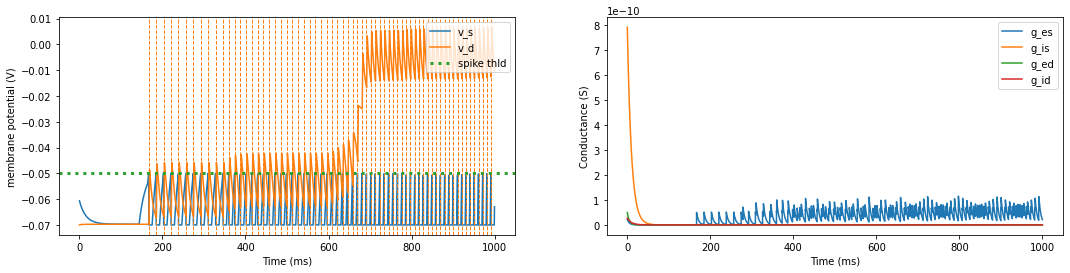

In [11]:
# CC Neurons

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_cc.t / ms, state_mon_cc.v_s[0], label='v_s')
plot(state_mon_cc.t / ms, state_mon_cc.v_d[0], label='v_d')
for (t, i) in zip(spike_mon_cc.t, spike_mon_cc.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('membrane potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_cc.t / ms, state_mon_cc.g_es[0], label='g_es')
plot(state_mon_cc.t / ms, state_mon_cc.g_is[0], label='g_is')
plot(state_mon_cc.t / ms, state_mon_cc.g_ed[0], label='g_ed')
plot(state_mon_cc.t / ms, state_mon_cc.g_id[0], label='g_id')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times CC: %s" % spike_mon_cc.t[:])

Spike times SST: [] s


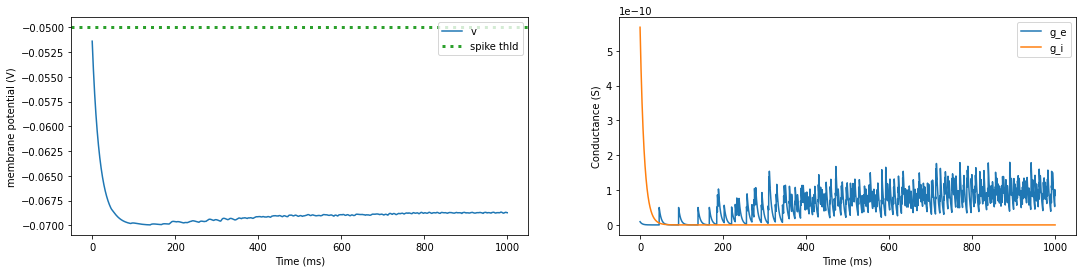

In [12]:
# SST Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_sst.t / ms, state_mon_sst.v[0], label='v')
for (t, i) in zip(spike_mon_sst.t, spike_mon_sst.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('membrane potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_sst.t / ms, state_mon_sst.g_e[0], label='g_e')
plot(state_mon_sst.t / ms, state_mon_sst.g_i[0], label='g_i')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times SST: %s" % spike_mon_sst.t[:])

Spike times PV: [] s


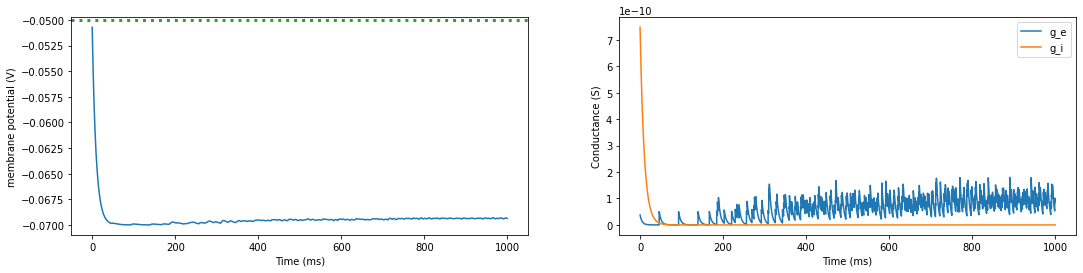

In [13]:
# PV Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_pv.t / ms, state_mon_pv.v[0], label='v')
for (t, i) in zip(spike_mon_pv.t, spike_mon_pv.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3)
xlabel('Time (ms)')
ylabel('membrane potential (V)')

subplot(1, 2, 2)
plot(state_mon_pv.t / ms, state_mon_pv.g_e[0], label='g_e')
plot(state_mon_pv.t / ms, state_mon_pv.g_i[0], label='g_i')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times PV: %s" % spike_mon_pv.t[:])

In [14]:
def bin(spiketime, dt):
    spiketime = np.array(spiketime)-spiketime[0]
    indexes = np.round(spiketime/dt).astype(int)
    A_t = np.zeros(indexes[-1]+1)
    for i in indexes:
        A_t[i] += 1
    return(A_t) 


def count_spikes_for_neuron_type(spike_mon):
    a = pd.Series([i for i in spike_mon.i], dtype=int)
    return a.value_counts()


@check_units(sim_duration=ms)
def compute_firing_rate_for_neuron_type(spike_mon, sim_duration):
    spikes_for_i = count_spikes_for_neuron_type(spike_mon)
    return (spikes_for_i / sim_duration)*Hz


def compute_input_selectivity(inputs):
    assert len(inputs) >= 2
    
    return np.abs(inputs[0] - inputs[1])/(inputs[0] + inputs[1])


@check_units(sim_duration=ms, result=1)
def compute_output_selectivity_for_neuron_type(spike_mon, sim_duration):
    rates_for_i = compute_firing_rate_for_neuron_type(spike_mon, sim_duration)
    assert len(rates_for_i) >= 2
    
    return np.abs(rates_for_i[0] - rates_for_i[1])/(rates_for_i[0] + rates_for_i[1])


def compute_interspike_intervals(spike_mon):
    by_neuron = []
    
    for neuron_index in spike_mon.spike_trains():
        interspike_intervals = np.diff(spike_mon.spike_trains()[neuron_index])
        by_neuron.append(interspike_intervals)
        
    return by_neuron

In [15]:
# Compute firing rate for each neuron group
firing_rates_cs = compute_firing_rate_for_neuron_type(spike_mon_cs, duration)
firing_rates_cc = compute_firing_rate_for_neuron_type(spike_mon_cc, duration)
firing_rates_sst = compute_firing_rate_for_neuron_type(spike_mon_sst, duration)
firing_rates_pv = compute_firing_rate_for_neuron_type(spike_mon_pv, duration)

print(f'Avg firing rate for CS neurons: {np.mean(firing_rates_cs) * Hz}')
print(f'Avg firing rate for CC neurons: {np.mean(firing_rates_cc) * Hz}')
print(f'Avg firing rate for SST neurons: {np.mean(firing_rates_sst) * Hz}')
print(f'Avg firing rate for PV neurons: {np.mean(firing_rates_pv) * Hz}')

Avg firing rate for CS neurons: 51.5 Hz
Avg firing rate for CC neurons: 68.5 Hz
Avg firing rate for SST neurons: nan Hz
Avg firing rate for PV neurons: nan Hz


In [16]:
# Compute input & output selectivity for CC & CS neuron groups
input_selectivity = compute_input_selectivity(I_ext_cs)
print(f'Input selectivity: {input_selectivity}')

output_selectivity_cs = compute_output_selectivity_for_neuron_type(spike_mon_cs, duration)
output_selectivity_cc = compute_output_selectivity_for_neuron_type(spike_mon_cc, duration)

print(f'Output selectivity CS: {output_selectivity_cs}')
print(f'Output selectivity CC: {output_selectivity_cc}')

Input selectivity: 0.02439024390243904
Output selectivity CS: 0.4174757281553398
Output selectivity CC: 0.0364963503649635


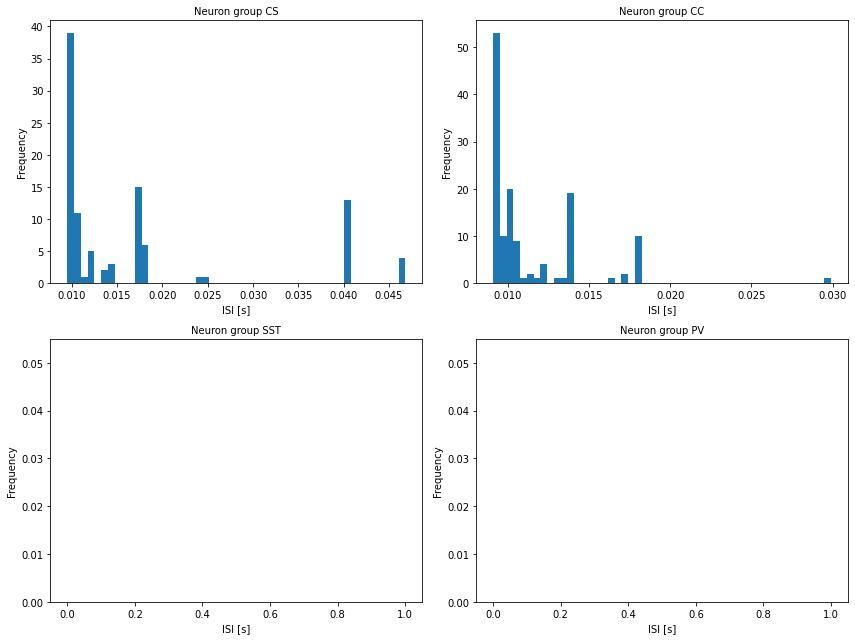

In [17]:
# Plot histogram of interspike intervals

interspike_intervals_cs = np.concatenate(compute_interspike_intervals(spike_mon_cs), axis=0)
interspike_intervals_cc = np.concatenate(compute_interspike_intervals(spike_mon_cc), axis=0)
interspike_intervals_sst = np.concatenate(compute_interspike_intervals(spike_mon_sst), axis=0)
interspike_intervals_pv = np.concatenate(compute_interspike_intervals(spike_mon_pv), axis=0)

index_to_ntype_dict = {
    0: 'CS',
    1: 'CC',
    2: 'SST',
    3: 'PV'
}
interspike_intervals = [interspike_intervals_cs, interspike_intervals_cc, interspike_intervals_sst, interspike_intervals_pv]

columns = 2
rows = int(len(interspike_intervals) / columns)

fig, axs = plt.subplots(rows, columns, figsize = (12, 9))

for (ntype_index, interspike_intervals_i) in enumerate(interspike_intervals):
    row_idx = int(ntype_index / columns)
    col_idx = ntype_index % columns
               
    axs[row_idx][col_idx].hist(interspike_intervals_i, bins=50)
    axs[row_idx][col_idx].axis(ymin=0)
    axs[row_idx][col_idx].set_title(f'Neuron group {index_to_ntype_dict[ntype_index]}', fontsize = 10)
    axs[row_idx][col_idx].set_ylabel("Frequency", fontsize = 10)
    axs[row_idx][col_idx].set_xlabel("ISI [s]", fontsize = 10)
    axs[row_idx][col_idx].tick_params(axis='both', which='major', labelsize=10)

    
plt.tight_layout()
plt.show()

In [18]:
def compute_autocorr(spike_intervals):
    autocorr = plt.acorr(spike_intervals, normed = True, maxlags=None)
    right_xaxis = autocorr[0][int(len(autocorr[1])/2):]
    right_acorr = autocorr[1][int(len(autocorr[1])/2):]
    return right_xaxis, right_acorr


def find_minimum_autocorr(acorr):
    minimum = None
    
    found_minimum = argrelextrema(acorr, np.less)[0]
    if len(found_minimum) == 1:
        if found_minimum[0] != 1:
            minimum = found_minimum[0]
    elif len(found_minimum) > 1:
        if argrelextrema(acorr, np.less)[0][0] != 1:
            minimum = argrelextrema(acorr, np.less)[0][0]
        else:
            minimum = argrelextrema(acorr, np.less)[0][1]
        
    return minimum


def plot_hist_autocorr(isi, index, bin_size=0.005):
    if len(isi) == 0:
        return None
    
    binned_isi = bin(np.sort(isi), bin_size)
    xaxis, acorr = compute_autocorr(binned_isi)
    xaxis = xaxis*bin_size
    minimum = find_minimum_autocorr(acorr)

    label_minimum = f"maxISI {str(np.round(xaxis[minimum], 4))} s"

    figure(figsize=(18, 4))
    subplot(1, 2, 1)
    n, bins, patches = hist(isi, bins=50)
    title(f'Neuron group {index_to_ntype_dict[index]}', fontsize = 10)
    ylabel("Frequency", fontsize = 10)
    xlabel("ISI [s]", fontsize = 10)
    tick_params(axis='both', which='major', labelsize=10)
    if minimum:
        vlines(xaxis[minimum], 0, np.max(n), label=label_minimum, color='red')
        legend()

    subplot(1, 2, 2)
    plot(xaxis, acorr, c='k')
    title(f'Neuron group {index_to_ntype_dict[index]}', fontsize = 10)
    xlabel("time lag [s]")
    ylabel("norm. autocorr.")
    if minimum:
        vlines(xaxis[minimum], 0, 1, label=label_minimum, color='red')
        legend()
        
    return xaxis[minimum] if minimum else None

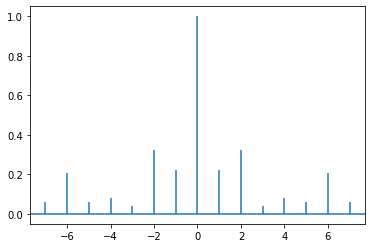

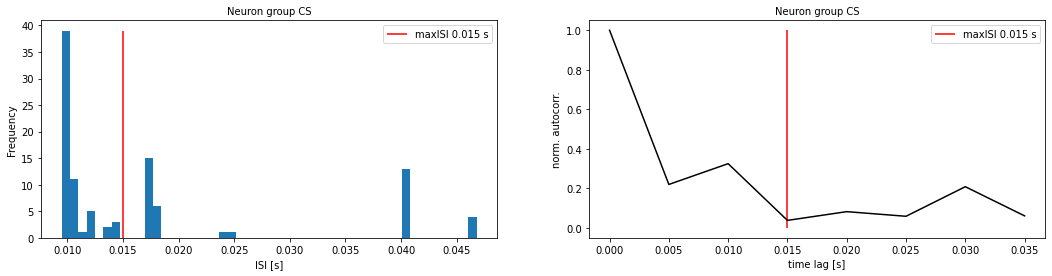

In [19]:
maxISI_cs = plot_hist_autocorr(interspike_intervals_cs, 0)

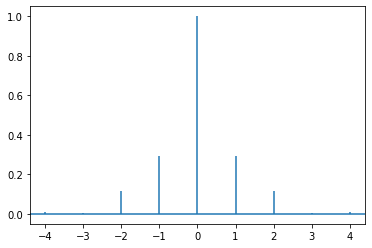

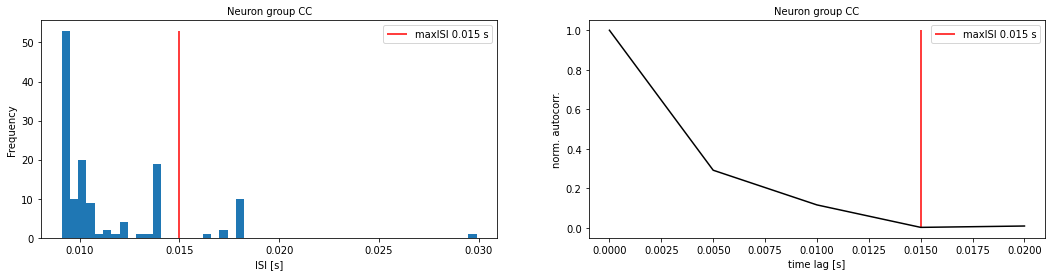

In [20]:
maxISI_cc = plot_hist_autocorr(interspike_intervals_cc, 1)

In [21]:
maxISI_sst = plot_hist_autocorr(interspike_intervals_sst, 2)

In [22]:
maxISI_pv = plot_hist_autocorr(interspike_intervals_pv, 3)

In [23]:
def compute_burst_mask(spikes, maxISI):
    isi = np.diff(spikes)
    mask = np.zeros(len(spikes))
    
    for i, isi_value in enumerate(isi):
        if isi_value <= maxISI:
            # also the next index because the isi vector has offset of 1 compare to mask/spikes
            mask[i] = mask[i+1] = 1 
    
    return mask


def compute_burst_trains(spike_mon, maxISI):
    burst_trains = {}
    for neuron_index in spike_mon.spike_trains():
        burst_mask = compute_burst_mask(spike_mon.spike_trains()[neuron_index], maxISI)
        burst_trains[neuron_index] = burst_mask
        
    return burst_trains


def compute_burst_lengths(burst_mask):
    "count how many series of consecutive occurances of 1 appear"
    
    burst_lengths = []
    idx = 0
    len_burst_mask = len(burst_mask)
    
    while idx < len_burst_mask:
        if burst_mask[idx] == 1:
            burst_length = 0
            
            while idx < len_burst_mask and burst_mask[idx] == 1: # iterate till the end of series
                burst_length += 1
                idx += 1
            
            burst_lengths.append(burst_length)
        
        idx += 1
        
    return burst_lengths


def compute_burst_lengths_by_neuron_group(burst_trains):
    burst_lengths = []
    for neuron_index in burst_trains:
        burst_lengths_by_neuron = compute_burst_lengths(burst_trains[neuron_index])
        burst_lengths.extend(burst_lengths_by_neuron)
        
    return burst_lengths

In [24]:
# Detect bursts

burst_trains_cs = compute_burst_trains(spike_mon_cs, maxISI_cs*second) if maxISI_cs else {}
burst_trains_cc = compute_burst_trains(spike_mon_cc, maxISI_cc*second) if maxISI_cc else {}
burst_trains_sst = compute_burst_trains(spike_mon_sst, maxISI_sst*second) if maxISI_sst else {}
burst_trains_pv = compute_burst_trains(spike_mon_pv, maxISI_pv*second) if maxISI_pv else {}

# Compute vector of burst lengths
burst_lengths_cs = compute_burst_lengths_by_neuron_group(burst_trains_cs)
burst_lengths_cc = compute_burst_lengths_by_neuron_group(burst_trains_cc)
burst_lengths_sst = compute_burst_lengths_by_neuron_group(burst_trains_sst)
burst_lengths_pv = compute_burst_lengths_by_neuron_group(burst_trains_pv)

print(f"Burst lengths vector for CS neurons: {burst_lengths_cs}")
print(f"Burst lengths vector for CC neurons: {burst_lengths_cc}")
print(f"Burst lengths vector for SST neurons: {burst_lengths_sst}")
print(f"Burst lengths vector for PV neurons: {burst_lengths_pv}")

Burst lengths vector for CS neurons: [62]
Burst lengths vector for CC neurons: [56, 67]
Burst lengths vector for SST neurons: []
Burst lengths vector for PV neurons: []
